In [15]:
# original code obtained from: https://www.kaggle.com/code/easmeileabrhim/rul-predict-by-cnn-lstm
# code has been modified

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os



In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
np.random.seed(401)
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.12.0
Numpy version:  1.24.3
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


In [17]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]

In [18]:
train_data = pd.read_csv("/Users/amoor22/Desktop/AUS Spring 2023/STA 401/project/data/engine_dataset.txt", sep= "\s+", header = None,names=columns )

In [19]:
train_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [20]:
def add_rul(g):
    g['RUL'] = max(g['cycle']) - g['cycle']
    return g

train = train_data.groupby('id').apply(add_rul)

/var/folders/pl/ymwzbz2n5lnd4vdrblrstns80000gn/T/ipykernel_13849/3314571197.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train = train_data.groupby('id').apply(add_rul)


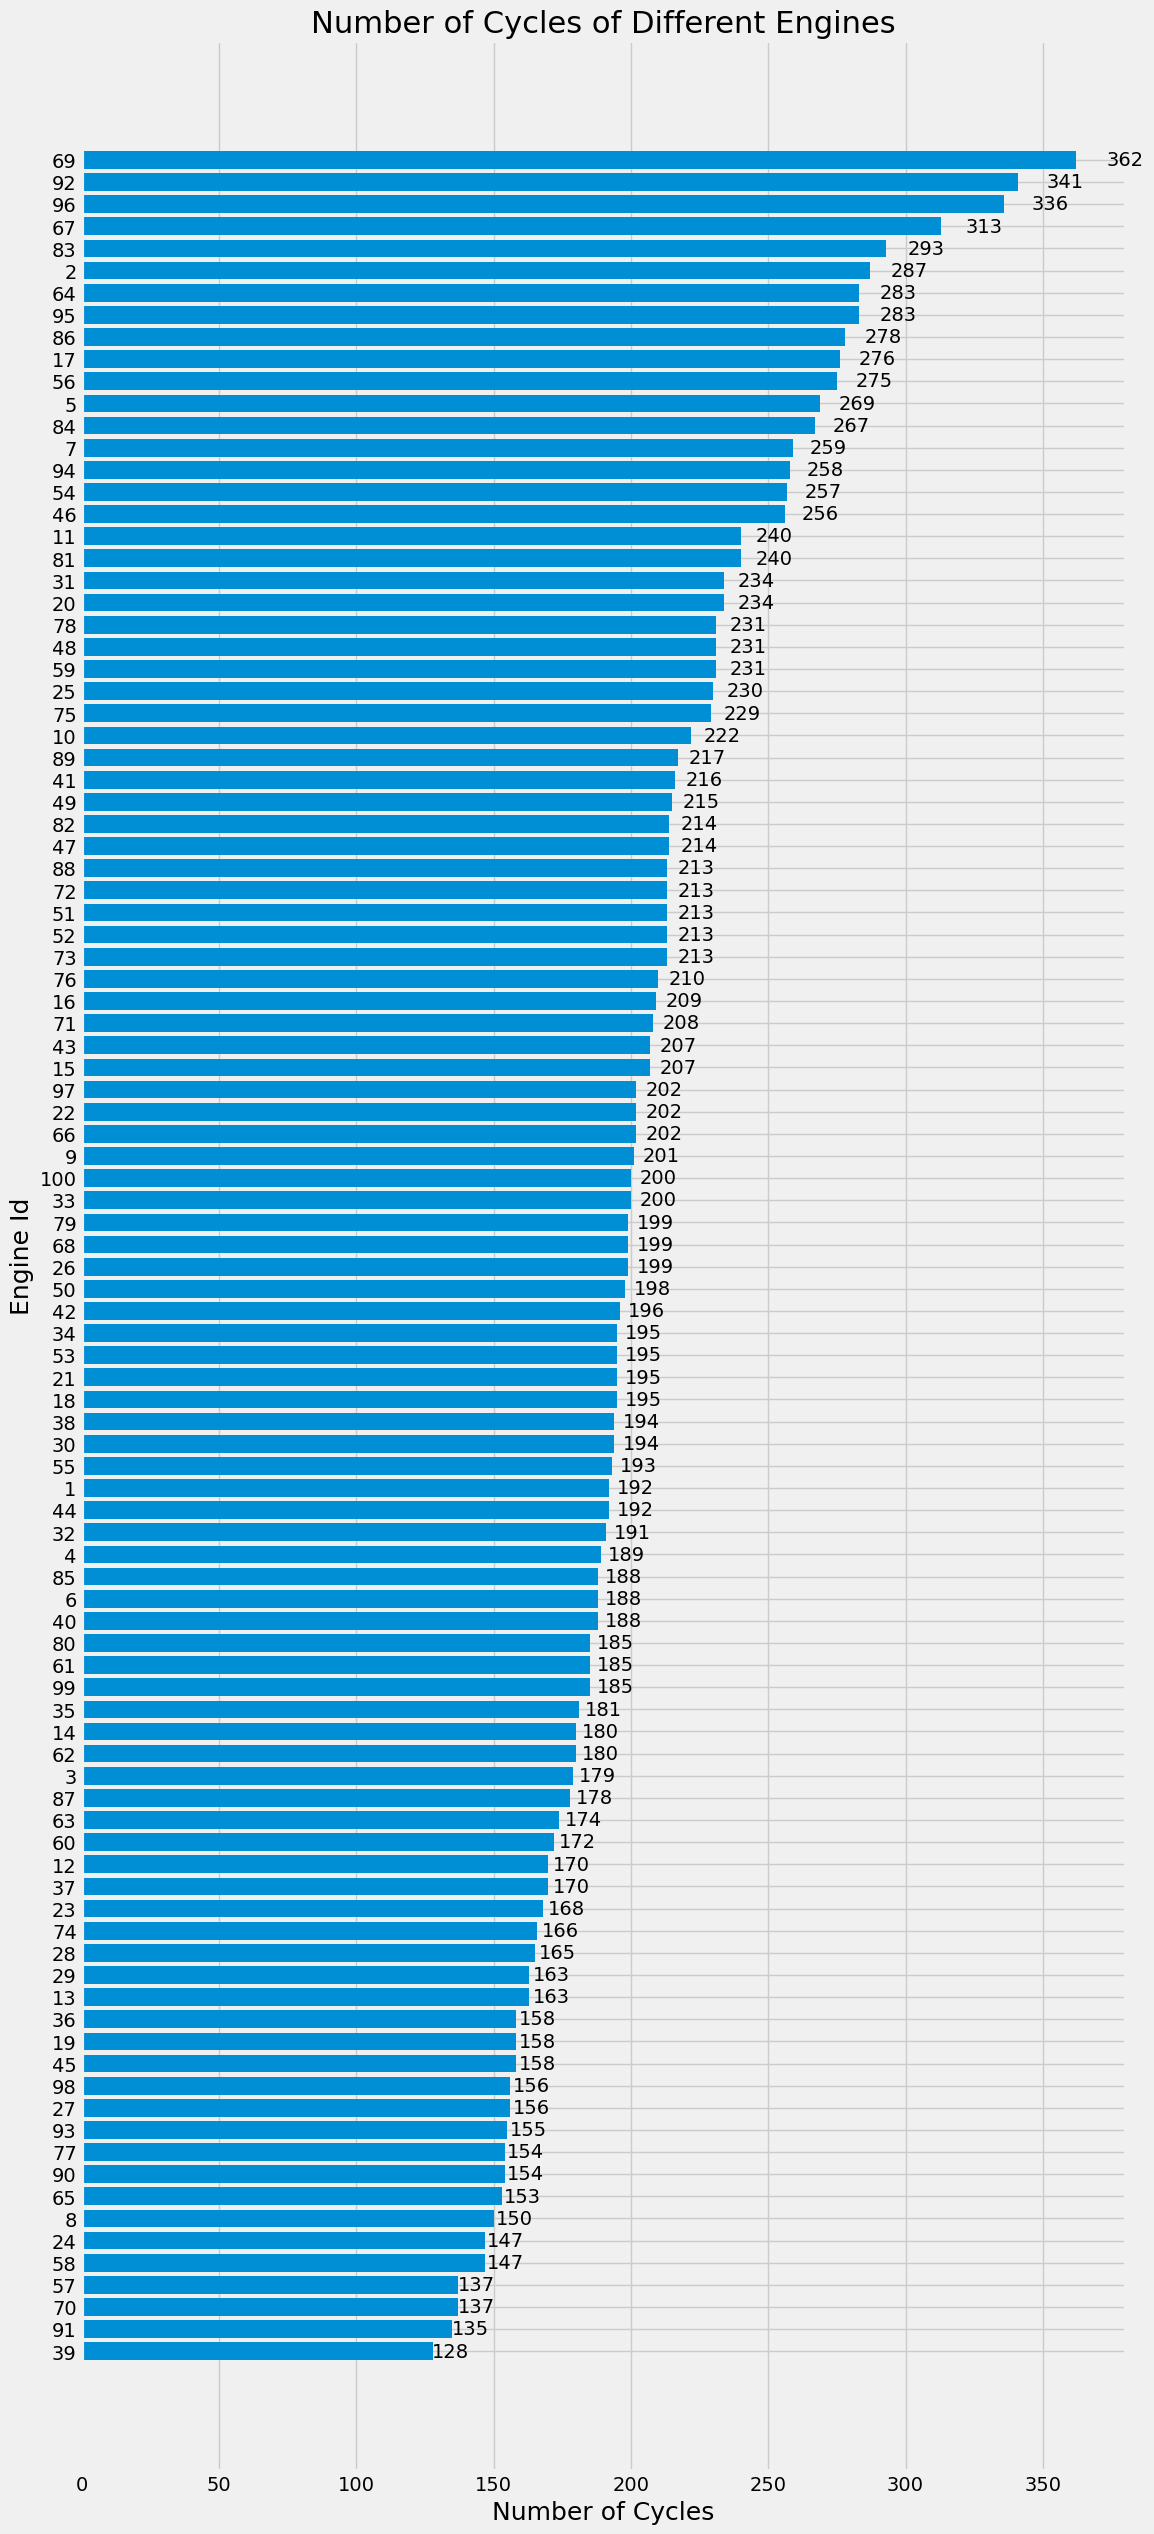

In [21]:
cnt_train=train_data[["id", "cycle"]].groupby("id").max().sort_values(by="cycle", ascending=True)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycle.values)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12, 30))
rects = ax.barh(cnt_ind, cnt_val)
ax.set_title("Number of Cycles of Different Engines", fontsize=22)
ax.set_ylabel("Engine Id", fontsize=18)
ax.set_xlabel("Number of Cycles", fontsize=18)
ax.grid(True)

for rect in rects:
    width = rect.get_width()
    plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
             '%d' % int(width),
             ha='center', va='center')

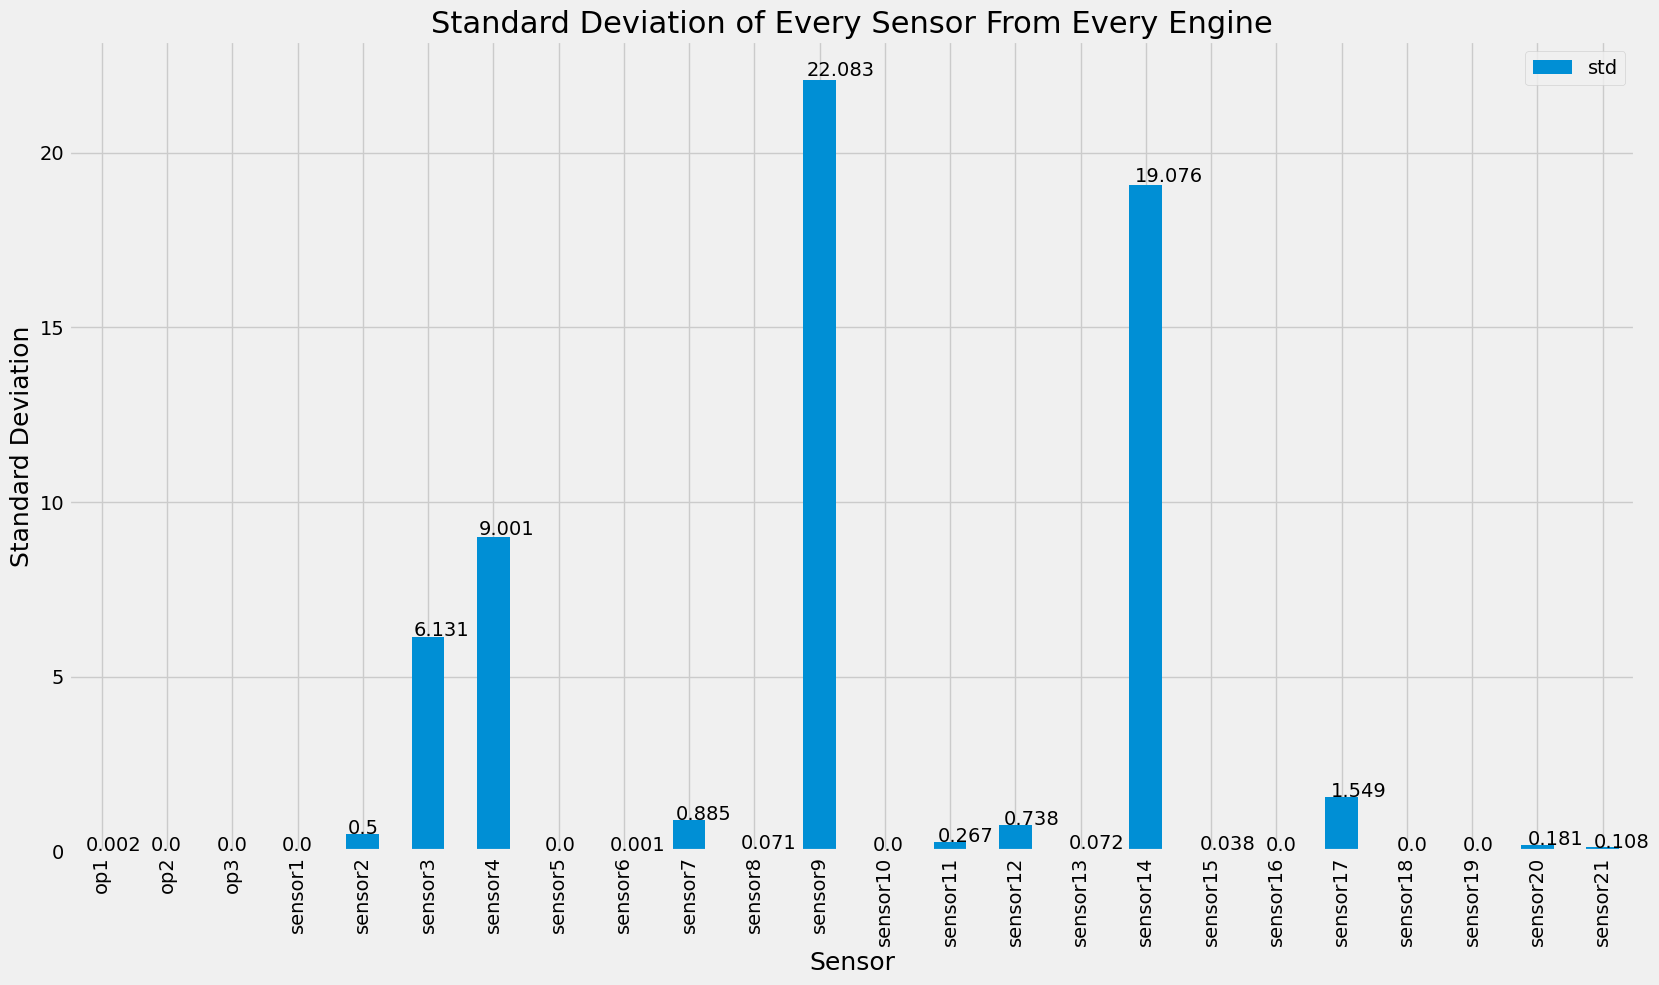

In [22]:
subset_stats = train_data.agg(['mean', 'std']).T[2:]
ax = subset_stats.plot.bar(figsize=(18,10), 
                           y="std")
ax.set_title("Standard Deviation of Every Sensor From Every Engine", fontsize=22)
ax.set_xlabel("Sensor", fontsize=18)
ax.set_ylabel("Standard Deviation", fontsize=18)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [26]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int32(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets


In [27]:
from sklearn.preprocessing import MinMaxScaler

In [30]:

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']
#[0,1,2,3,4,5,9,10,11,14,20,21,22,23,24,25]
window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []



#columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

# train_data_first_column = train_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data)

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])

num_train_machines = len(train_data[0].unique())


# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)



print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)


Processed trianing data shape:  (17731, 30, 15)
Processed training ruls shape:  (17731,)


In [31]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                              processed_train_targets,
                                                                                              test_size = 0.3,
                                                                                              random_state = 83)

processed_val_data, processed_test_data, processed_val_targets, true_rul = train_test_split(processed_val_data,
                                                                                              processed_val_targets,
                                                                                              test_size = 1/3.,
                                                                                              random_state = 83)

print("Processed train data shape: ", processed_train_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)

print("Processed test data shape: ", processed_test_data.shape)
print("Processed test target shape: ", true_rul.shape)

Processed train data shape:  (12411, 30, 15)
Processed train targets shape:  (12411,)
Processed test data shape:  (1774, 30, 15)
Processed test target shape:  (1774,)


from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model 
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model 
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM


In [34]:
def create_model(lr=0.001, drop_dense=0.2):
    model = Sequential()
    intput_shape=(window_length, processed_train_data.shape[2])
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'relu'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    return model

In [35]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

# placeholder only
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

import keras.backend as K

def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_model()
model.compile(optimizer=opt, loss='mse', metrics=[r2_score])
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                validation_data = (processed_val_data, processed_val_targets),
                callbacks = callback,
                batch_size = 64, verbose = 2)

2023-05-15 17:41:02.923087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-15 17:41:02.924119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2023-05-15 17:41:03.700540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 17:41:03.701491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 17:41:03.702195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

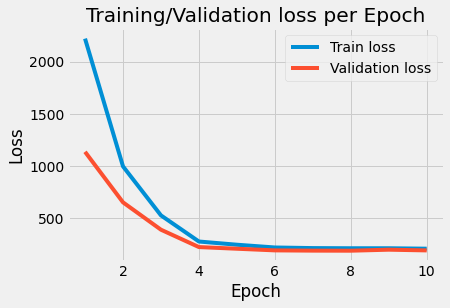

In [153]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + history.history['loss'])
ax.plot([None] + history.history['val_loss'])

ax.legend(['Train loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

rul_pred = model.predict(processed_test_data).reshape(-1)
# preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
# mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
#                              for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

RMSE = np.sqrt(mean_squared_error(true_rul, rul_pred))
print("RMSE: {:.2f}".format(RMSE))

MSE = mean_squared_error(true_rul, rul_pred)
print("MSE: {:.2f}".format(MSE))

r2 = r2_score(true_rul, rul_pred)
print("R^2 score: {:.2f}".format(r2))

In [ ]:
y_pred = rul_pred
y_true = true_rul
# Scatter plot of predicted vs true values
plt.scatter(y_pred, y_true)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlim([0,110])
plt.ylim([0,110])
plt.title('Scatter plot of predicted vs true values')
plt.show()

# Residual plot
residuals = y_true - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.xlim([0,80])
plt.title('Residual plot')
plt.show()

# true on pred plot
lw = 1
plt.plot(y_true, label = "True RUL", color = "red", linewidth=lw)
plt.plot(y_pred, label = "Pred RUL", color = "blue", linewidth=lw)
plt.xlim([0,100])
plt.legend(loc='lower right')
plt.show()